---
title: "Unit 1: Earth Engine Python API"
---

:::{tip}
This unit is based on the tutorial available [here](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api)
:::

## Install the API first

Follow [these instrucctions](https://developers.google.com/earth-engine/guides/python_install-conda#linux_6) to install the GEE Python API on a conda environment

## Run me first

First of all, run the following cell to initialize the API.

In [1]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-ializarazos')

## Getting started with Collections

In the Earth Engine Data Catalog, datasets can be of different types:

- *Features* which are geometric objects with a list of properties. For example, a watershed with some properties such as name and area, is an ee.Feature.

- *Images* which are like features, but may include several bands. For example, the ground elevation given by the USGS [here](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003) is an ee.Image.

- *Collections* which are groups of features or images. For example, the [Global Administrative Unit Layers](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level0) giving administrative boundaries is a ee.FeatureCollection and the [MODIS Land Surface Temperature dataset](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1) is an ee.ImageCollection.

In the following sections, we work with the MODIS land cover (LC), the MODIS land surface temperature (LST) and with the USGS ground elevation (ELV), which are ee.ImageCollections. The dataset descriptions provide us with all the information we need to import and manipulate these datasets: the availability, the provider, the Earth Engine Snippet, and the available bands associated with images in the collection.

Now, to import the LC, LST and ELV collections, we can copy and paste the Earth Engine Snippets:

In [2]:
# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/061/MCD12Q1')

# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/061/MOD11A1')

# Import the USGS ground elevation image.
elv = ee.Image('USGS/SRTMGL1_003')

All of these images come in a different resolution, frequency, and possibly projection, ranging from daily images in a 1 km resolution for LST (hence an ee.ImageCollection — a collection of several ee.Images) to a single image representing data for the year 2000 in a 30 m resolution for the ELV. While we need to have an eye on the frequency, GEE takes care of resolution and projection by resampling and reprojecting all data we are going to work with to a common projection (learn more about [projections in Earth Engine](https://developers.google.com/earth-engine/guides/projections)). We can define the resolution (called scale in GEE) whenever necessary and of course have the option to force no reprojection.

As you can see in the description of the datasets, they include several sets of information stored in several bands. For example, these bands are associated with the LST collection:

- LST_Day_1km: Daytime Land Surface Temperature

- Day_view_time: Local time of day observation

- LST_Night_1km: Nighttime Land Surface Temperature

- etc.

The description page of the collection tells us that the name of the band associated with the daytime LST is LST_Day_1km which is in units of Kelvin. In addition, values are ranging from 7,500 to 65,535 with a corrective scale of 0.02.

Then, we have to filter the collection on the period of time we want. We can do that using the filterDate() method. We also need to select the bands we want to work with. Therefore, we decide to focus on daytime LST so we select the daytime band LST_Day_1km and its associated quality indicator QC_Day with the select() method.

In [3]:
# Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive).
f_date = '2020-01-01'

# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

Now, we can either upload existing shape files or define some points with longitude and latitude coordinates where we want to know more about LC, LST and ELV. For this example, let's use two point locations:

The first one in the urban area of Bogotá, Colombia
The second one, 30 kilometers away from the city center, in a rural area

In [4]:
# Define the urban location of interest as a point near Bogotá.
u_lon = -74.08698
u_lat = 4.64202  
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Define the rural location of interest as a point away from the city.
r_lon = -74.215
r_lat = 4.685
r_poi = ee.Geometry.Point(r_lon, r_lat)

We can easily get information about our region/point of interest using the following methods (to get more information about available methods and required arguments, please visit the API documentation here):

- sample(): samples the image (does NOT work for an ee.ImageCollection — we'll talk about sampling an ee.ImageCollection later) according to a given geometry and a scale (in meters) of the projection to sample in. It returns an ee.FeatureCollection.

- first(): returns the first entry of the collection,

- get(): to select the appropriate band of your Image/Collection,

- getInfo(): evaluates server-side expression graph and transfers result to client.

Then we can query the ground elevation and LST around our point of interest using the following commands. Please be careful when evaluating LST. According to the dataset description, the value should be corrected by a factor of 0.02 to get units of Kelvin (do not forget the conversion). To get the mean multi-annual daytime LST, we use the mean() collection reduction method on the LST ee.ImageCollection. (The following run might take about 15-20 seconds)

In [5]:
scale = 1000  # scale in meters

# Print the elevation near Lyon, France.
elv_urban_point = elv.sample(u_poi, scale).first().get('elevation').getInfo()
print('Ground elevation at urban point:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_urban_point = lc.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at urban point is:', lc_urban_point)

Ground elevation at urban point: 2555 m
Average daytime LST at urban point: 27.98 °C
Land cover value at urban point is: 13


Going back to the band description of the lc dataset, we see that a lc value of "13" corresponds to an urban land. You can run the above cells with the rural point coordinates if you want to notice a difference.

## Get a time series

Now that you see we can get geospatial information about a place of interest pretty easily, you may want to inspect a time series, probably make some charts and calculate statistics about a place. Hence, we import the data at the given locations using the getRegion() method.

In [6]:
# Get the data for the pixel intersecting the point in urban area.
lst_u_poi = lst.getRegion(u_poi, scale).getInfo()

# Get the data for the pixel intersecting the point in rural area.
lst_r_poi = lst.getRegion(r_poi, scale).getInfo()

# Preview the result.
lst_u_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2017_01_01',
  -74.08855305775754,
  4.639798442477328,
  1483228800000,
  14795,
  145],
 ['2017_01_02', -74.08855305775754, 4.639798442477328, 1483315200000, None, 2],
 ['2017_01_03',
  -74.08855305775754,
  4.639798442477328,
  1483401600000,
  15217,
  81],
 ['2017_01_04', -74.08855305775754, 4.639798442477328, 1483488000000, None, 2]]

Printing the first 5 lines of the result shows that we now have arrays full of data. As we can see several None values appear in the LST_Day_1km column. The associated quality indicator QC_Day indicates a value of 2 meaning that the LST is not calculated because of cloud effects.

We now define a function to transform this array into a pandas Dataframe which is much more convenient to manipulate.

In [7]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

We apply this function to get the two time series we want (and print one).

In [8]:
lst_df_urban = ee_array_to_df(lst_u_poi,['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)

# Do the same for the rural point.
lst_df_rural = ee_array_to_df(lst_r_poi,['LST_Day_1km'])
lst_df_rural['LST_Day_1km'] = lst_df_rural['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_urban.head()

,time,datetime,LST_Day_1km
0,1483228800000,2017-01-01,22.75
2,1483401600000,2017-01-03,31.19
5,1483660800000,2017-01-06,21.95
10,1484092800000,2017-01-11,17.27
11,1484179200000,2017-01-12,29.01


Now that we have our data in a good shape, we can easily make plots and compare the trends. As the area of Bogotá, Continental experiences a continental climate, we expect that LST has a seasonality influence and the sinusoidal trend described by Stallman (1965) reading as follow:

$$LST(t) = LST_0 + \frac{\Delta_{LST}}{2}sin(\frac{2{\pi}t}{\tau}+\phi)$$

where:

$LST(t)$ represents the mean annual LST,
$\Delta_{LST}$ represents the amplitude between maximal and minimal LST,
$\tau$ represents the period of oscillation of LST, and
$\phi$ represents an offset needed to adjust the time when $LST(t) = LST_0$.

Consequently, on the top of the data scatter plot, we plot the fitting curve using the scipy library:




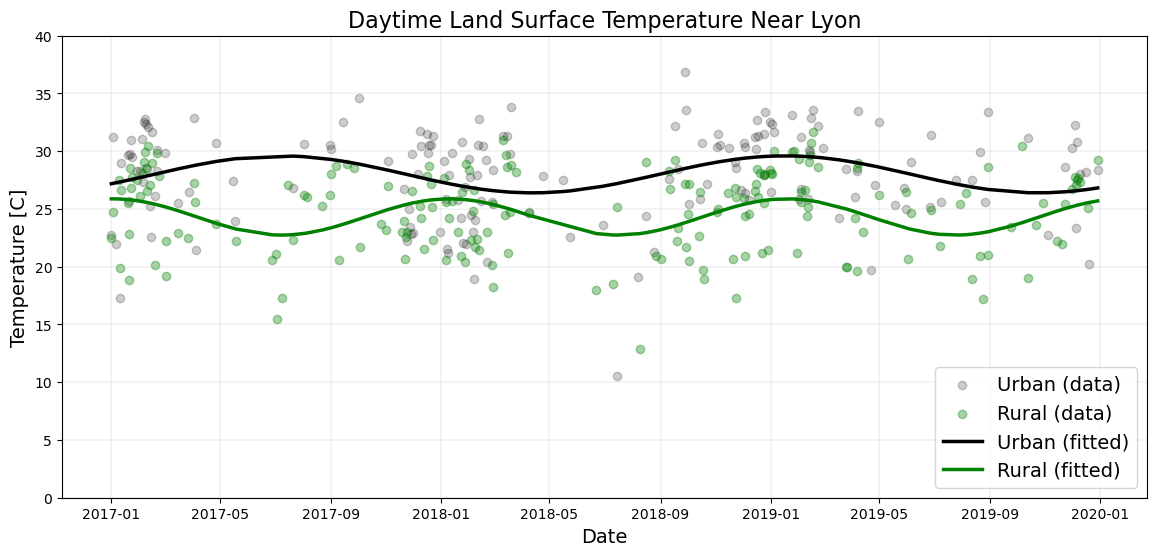

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
##%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))  # urban
x_data_r = np.asanyarray(lst_df_rural['time'].apply(float))  # rural

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))  # urban
y_data_r = np.asanyarray(lst_df_rural['LST_Day_1km'].apply(float))  # rural

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])
params_r, params_covariance_r = optimize.curve_fit(
    fit_func, x_data_r, y_data_r, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km'],
           c='black', alpha=0.2, label='Urban (data)')
ax.scatter(lst_df_rural['datetime'], lst_df_rural['LST_Day_1km'],
           c='green', alpha=0.35, label='Rural (data)')

# Add fitting curves.
ax.plot(lst_df_urban['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Urban (fitted)', color='black', lw=2.5)
ax.plot(lst_df_rural['datetime'],
        fit_func(x_data_r, params_r[0], params_r[1], params_r[2], params_r[3]),
        label='Rural (fitted)', color='green', lw=2.5)

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Near Lyon', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()